# RANDRIANAMBININA Tokiniaina Jean Anicet Jonhia
Classification et interprétation d’images par réseaux de neurones

# Projet guidé — Classification et interprétation d'images (CIFAR-10)

**Objectif** : Construire et entraîner deux modèles (MLP baseline et CNN final) sur CIFAR-10, évaluer, interpréter (Grad-CAM, matrice de confusion) et produire les livrables demandés.

**Instructions** : Exécuter les cellules dans l'ordre. Le notebook est structuré en sections exécutables et commentées.


## Prérequis
Installez les librairies si nécessaire (exécuter dans une cellule si vous êtes sur Colab / environnement propre):

In [1]:
# !pip install -q tensorflow matplotlib scikit-learn seaborn
# Décommentez la ligne ci-dessus si vous devez installer les dépendances (par ex. sur Google Colab).
!pip install -q tensorflow matplotlib scikit-learn seaborn


## 1) Imports et configuration globale

In [2]:
# Imports essentiels et configuration de base
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Reproductibilité (note: TF peut encore introduire de la non-déterminisme selon l'environnement)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Dossier de sortie
OUTDIR = 'outputs'
os.makedirs(OUTDIR, exist_ok=True)

print('TensorFlow version:', tf.__version__)
print('Output directory:', OUTDIR)


TensorFlow version: 2.19.0
Output directory: outputs


## 2) Chargement et préparation des données — CIFAR-10
On rassemble l'ensemble standard (50k train + 10k test) puis on refait un split 70/15/15 stratifié.


In [3]:
# Chargement CIFAR-10 depuis Keras datasets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# y arrays are shape (n,1); flatten to (n,)
y_train = y_train.ravel()
y_test = y_test.ravel()

# Concaténation pour refonte du split
X = np.vstack([x_train, x_test])
y = np.concatenate([y_train, y_test])

print('Total images:', X.shape, 'Total labels:', y.shape)

# Split 70% train, 15% val, 15% test (stratifié)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=RANDOM_STATE)
rel_val = 0.15 / (1 - 0.15)  # proportion validation par rapport à X_temp
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=rel_val, stratify=y_temp, random_state=RANDOM_STATE)

print('Train shape:', X_train.shape, 'Val shape:', X_val.shape, 'Test shape:', X_test.shape)

# Normalisation entre 0 et 1
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot des labels pour Keras
num_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_val_cat = keras.utils.to_categorical(y_val, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

# Classe names CIFAR-10
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print('Exemple image shape:', X_train[0].shape, 'Classes:', class_names)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step
Total images: (60000, 32, 32, 3) Total labels: (60000,)
Train shape: (42000, 32, 32, 3) Val shape: (9000, 32, 32, 3) Test shape: (9000, 32, 32, 3)
Exemple image shape: (32, 32, 3) Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 3) Visualisation — quelques exemples par classe

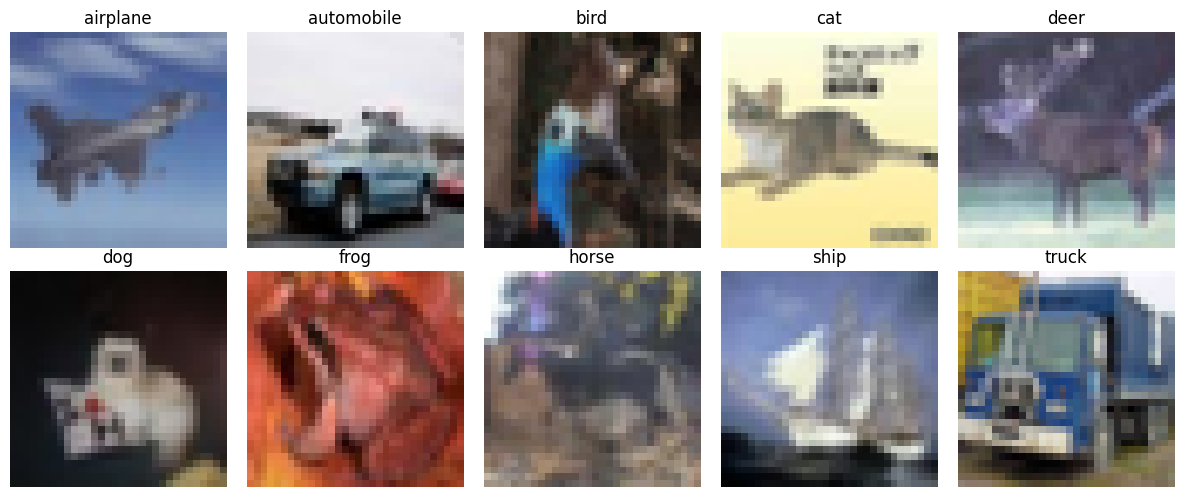

In [4]:
# Afficher quelques images d'entraînement (une par classe)
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.ravel()
for i, cls in enumerate(range(num_classes)):
    idx = np.where(y_train == cls)[0][0]
    axes[i].imshow(X_train[idx])
    axes[i].set_title(class_names[cls])
    axes[i].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'sample_per_class.png'), dpi=150)
plt.show()


## 4) Baseline — MLP simple
Un MLP qui aplati l'image et utilise quelques couches Dense. Sert de baseline pour comparaison.


In [5]:
def build_mlp(input_shape, num_classes, hidden_units=[512, 256], dropout=0.5):
    """Construit un MLP simple.
    input_shape : shape de l'image (H,W,C)
    """
    model = keras.Sequential(name='MLP_baseline')
    model.add(layers.Flatten(input_shape=input_shape))
    for units in hidden_units:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

mlp = build_mlp(X_train.shape[1:], num_classes)
mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mlp.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "MLP_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,707,274 (6.51 MB)

 Trainable params: 1,707,274 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

### Entraînement du MLP
Paramètres d'entraînement (epochs 30, batch_size 64). EarlyStopping pour éviter l'overfitting.


In [6]:
EPOCHS = 30
BATCH_SIZE = 64

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
]

history_mlp = mlp.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=2
)

# Sauvegarder modèle baseline
mlp.save(os.path.join(OUTDIR, 'mlp_baseline.h5'))
print('MLP sauvegardé.')


Epoch 1/30
657/657 - 22s - 33ms/step - accuracy: 0.1740 - loss: 2.1750 - val_accuracy: 0.2172 - val_loss: 2.0709
Epoch 2/30
657/657 - 17s - 26ms/step - accuracy: 0.2091 - loss: 2.0622 - val_accuracy: 0.2672 - val_loss: 1.9662
Epoch 3/30
657/657 - 17s - 26ms/step - accuracy: 0.2196 - loss: 2.0314 - val_accuracy: 0.2413 - val_loss: 1.9929
Epoch 4/30
657/657 - 18s - 27ms/step - accuracy: 0.2283 - loss: 2.0167 - val_accuracy: 0.2894 - val_loss: 1.9574
Epoch 5/30
657/657 - 19s - 29ms/step - accuracy: 0.2274 - loss: 2.0093 - val_accuracy: 0.2736 - val_loss: 1.9739
Epoch 6/30
657/657 - 21s - 31ms/step - accuracy: 0.2320 - loss: 2.0048 - val_accuracy: 0.2622 - val_loss: 1.9789
Epoch 7/30
657/657 - 17s - 26ms/step - accuracy: 0.2350 - loss: 2.0040 - val_accuracy: 0.2739 - val_loss: 1.9416
Epoch 8/30
657/657 - 18s - 27ms/step - accuracy: 0.2352 - loss: 1.9965 - val_accuracy: 0.2613 - val_loss: 2.0016
Epoch 9/30
657/657 - 17s - 26ms/step - accuracy: 0.2355 - loss: 1.9959 - val_accuracy: 0.2832 - 

MLP sauvegardé.


### Courbes d'entraînement — MLP

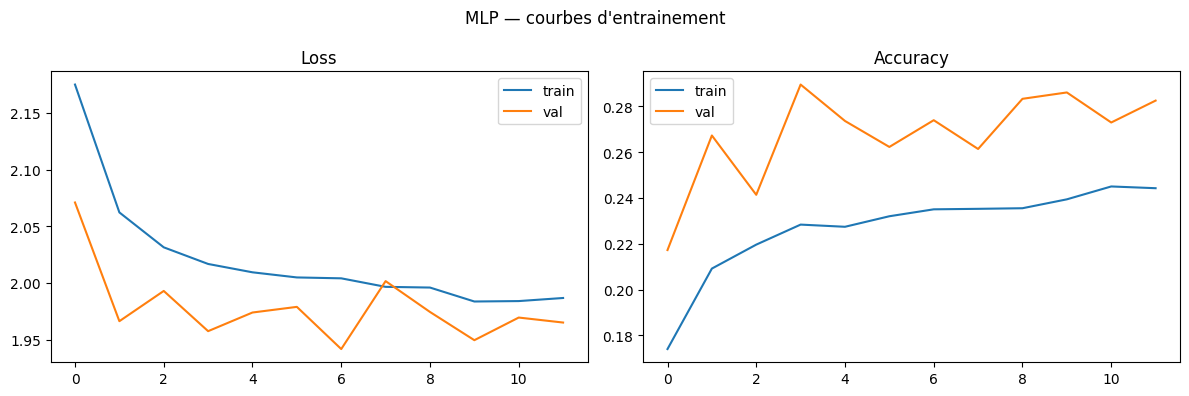

In [7]:
def plot_history(history, title, outpath=None):
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    # loss
    axes[0].plot(history.history['loss'], label='train')
    axes[0].plot(history.history['val_loss'], label='val')
    axes[0].set_title('Loss')
    axes[0].legend()
    # acc
    axes[1].plot(history.history['accuracy'], label='train')
    axes[1].plot(history.history['val_accuracy'], label='val')
    axes[1].set_title('Accuracy')
    axes[1].legend()
    plt.suptitle(title)
    plt.tight_layout()
    if outpath:
        plt.savefig(outpath, dpi=150)
    plt.show()

plot_history(history_mlp, 'MLP — courbes d\'entrainement', os.path.join(OUTDIR, 'mlp_history.png'))


### Évaluation MLP sur test set

Test loss, Test accuracy: [1.938946008682251, 0.28111112117767334]
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification report (MLP):

              precision    recall  f1-score   support

    airplane       0.37      0.45      0.41       900
  automobile       0.54      0.14      0.22       900
        bird       0.27      0.01      0.02       900
         cat       0.19      0.20      0.19       900
        deer       0.19      0.14      0.16       900
         dog       0.48      0.10      0.17       900
        frog       0.23      0.65      0.34       900
       horse       0.24      0.22      0.23       900
        ship       0.46      0.18      0.26       900
       truck       0.30      0.72      0.43       900

    accuracy                           0.28      9000
   macro avg       0.33      0.28      0.24      9000
weighted avg       0.33      0.28      0.24      9000



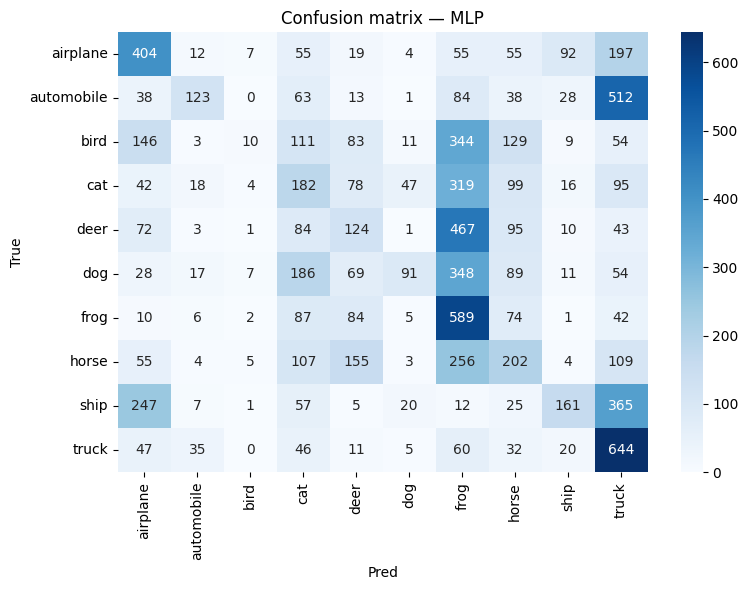

In [8]:
mlp_eval = mlp.evaluate(X_test, y_test_cat, verbose=0)
print('Test loss, Test accuracy:', mlp_eval)

# Prédictions et rapport
y_pred_mlp = np.argmax(mlp.predict(X_test), axis=1)
print('\nClassification report (MLP):\n')
print(classification_report(y_test, y_pred_mlp, target_names=class_names))

cm_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(8,6))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion matrix — MLP')
plt.ylabel('True')
plt.xlabel('Pred')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'cm_mlp.png'), dpi=150)
plt.show()


## 5) Modèle final — CNN (3 blocs convolutionnels)
Architecture raisonnable pour CIFAR-10: 3 blocs Conv2D + BatchNorm + MaxPool, puis Dense.


In [9]:
def build_cnn(input_shape, num_classes, dropout=0.4):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name='CNN_3blk')
    return model

cnn = build_cnn(X_train.shape[1:], num_classes)
cnn.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()


Model: "CNN_3blk"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 621,258 (2.37 MB)

 Trainable params: 620,810 (2.37 MB)

 Non-trainable params: 448 (1.75 KB)

### Entraînement du CNN
Epochs 40, batch size 64, callbacks: EarlyStopping + ModelCheckpoint.


In [12]:
EPOCHS_CNN = 4
BATCH_SIZE = 64
callbacks_cnn = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(os.path.join(OUTDIR, 'best_cnn.h5'), save_best_only=True, monitor='val_loss')
]

history_cnn = cnn.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS_CNN,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_cnn,
    verbose=2
)

# Sauvegarde modèle final
cnn.save(os.path.join(OUTDIR, 'cnn_final.h5'))
print('CNN sauvegardé.')


Epoch 1/4


657/657 - 123s - 187ms/step - accuracy: 0.8244 - loss: 0.5026 - val_accuracy: 0.6879 - val_loss: 0.9962
Epoch 2/4
657/657 - 121s - 184ms/step - accuracy: 0.8438 - loss: 0.4420 - val_accuracy: 0.6944 - val_loss: 1.1418
Epoch 3/4
657/657 - 147s - 224ms/step - accuracy: 0.8618 - loss: 0.3893 - val_accuracy: 0.6798 - val_loss: 1.2745
Epoch 4/4
657/657 - 141s - 215ms/step - accuracy: 0.8750 - loss: 0.3516 - val_accuracy: 0.7033 - val_loss: 1.1952


CNN sauvegardé.


### Courbes d'entraînement — CNN

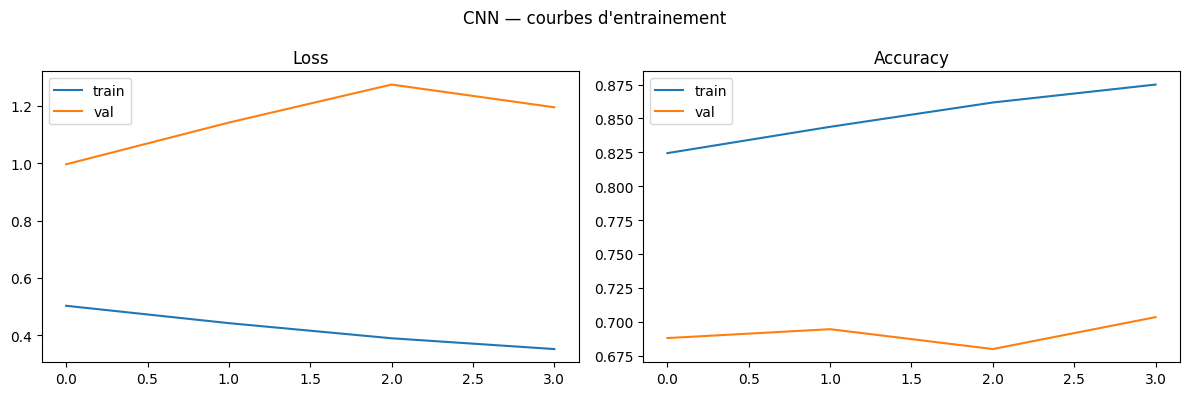

In [13]:
lot_history(history_cnn, 'CNN — courbes d\'entrainement', os.path.join(OUTDIR, 'cnn_history.png'))


### Évaluation du CNN sur le test set

Test loss, Test accuracy: [0.9793652296066284, 0.6896666884422302]
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step

Classification report (CNN):

              precision    recall  f1-score   support

    airplane       0.72      0.79      0.75       900
  automobile       0.68      0.94      0.79       900
        bird       0.47      0.78      0.58       900
         cat       0.56      0.51      0.53       900
        deer       0.76      0.49      0.60       900
         dog       0.75      0.49      0.59       900
        frog       0.67      0.84      0.75       900
       horse       0.75      0.79      0.77       900
        ship       0.95      0.67      0.79       900
       truck       0.92      0.60      0.72       900

    accuracy                           0.69      9000
   macro avg       0.72      0.69      0.69      9000
weighted avg       0.72      0.69      0.69      9000



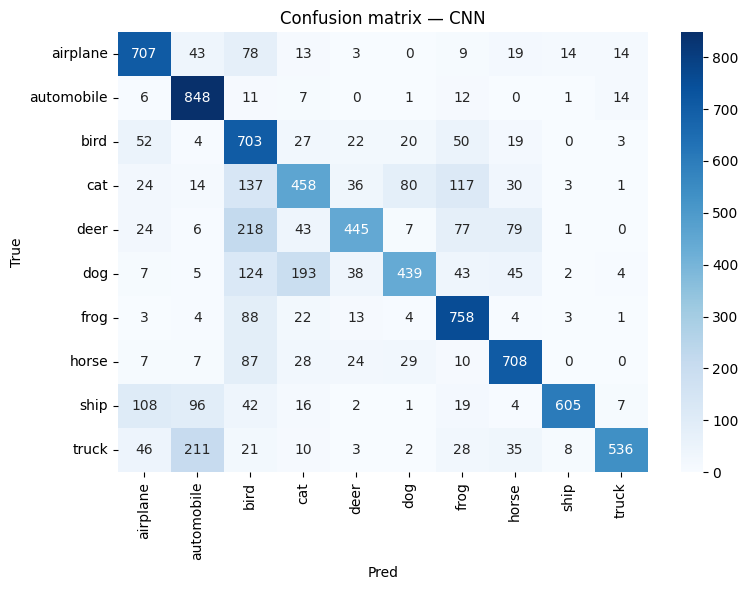

In [14]:
cnn_eval = cnn.evaluate(X_test, y_test_cat, verbose=0)
print('Test loss, Test accuracy:', cnn_eval)

# Prédictions et rapport
y_pred_cnn = np.argmax(cnn.predict(X_test), axis=1)
print('\nClassification report (CNN):\n')
print(classification_report(y_test, y_pred_cnn, target_names=class_names))

cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(8,6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion matrix — CNN')
plt.ylabel('True')
plt.xlabel('Pred')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'cm_cnn.png'), dpi=150)
plt.show()


## 6) Exemples — prédictions correctes et erreurs
Affichage de quelques exemples correctement classés et quelques erreurs pour analyse qualitative.

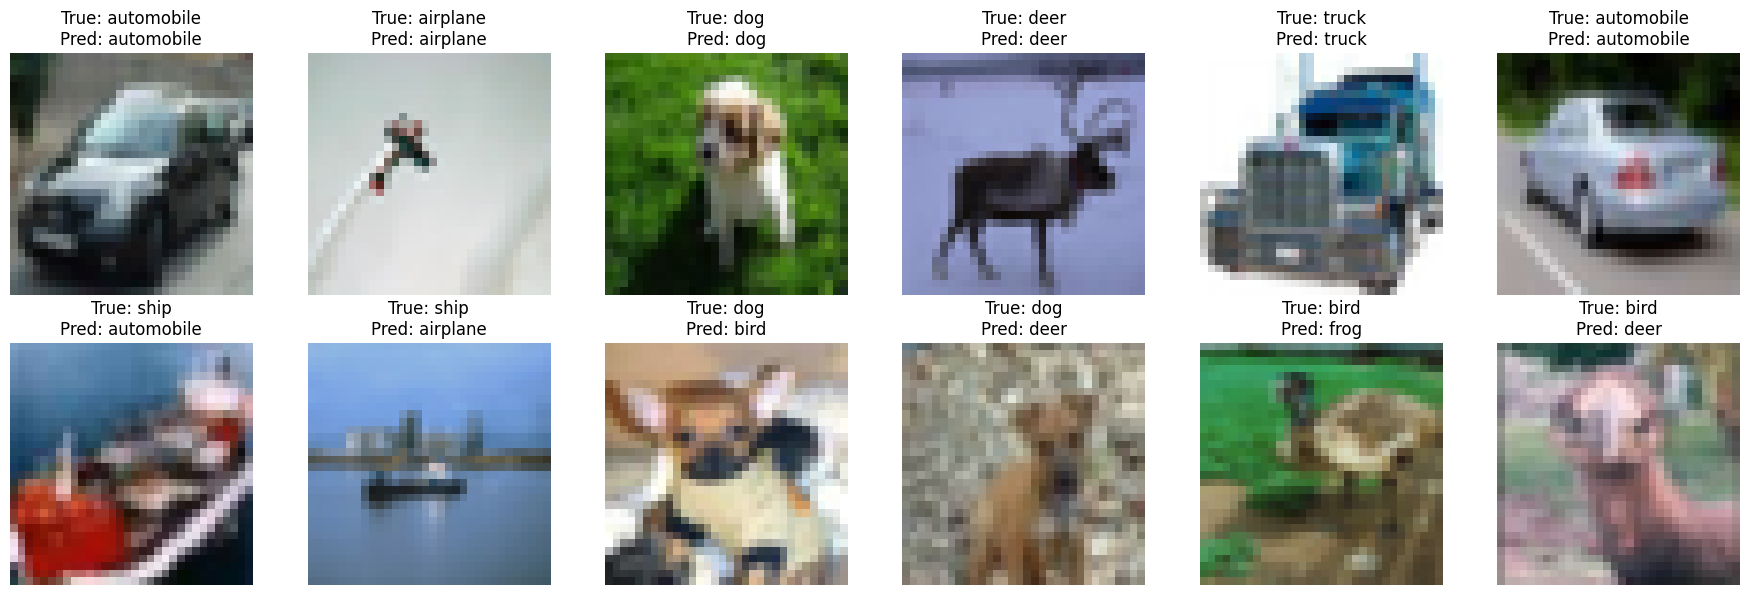

In [15]:
def show_examples(X, y_true, y_pred, class_names, n_examples=6):
    correct_idx = np.where(y_true == y_pred)[0]
    wrong_idx = np.where(y_true != y_pred)[0]

    fig, axes = plt.subplots(2, n_examples, figsize=(3*n_examples,6))
    for i in range(n_examples):
        # correct
        idxc = correct_idx[i]
        axes[0,i].imshow(X[idxc])
        axes[0,i].set_title(f'True: {class_names[y_true[idxc]]}\nPred: {class_names[y_pred[idxc]]}')
        axes[0,i].axis('off')
        # wrong
        idxw = wrong_idx[i]
        axes[1,i].imshow(X[idxw])
        axes[1,i].set_title(f'True: {class_names[y_true[idxw]]}\nPred: {class_names[y_pred[idxw]]}')
        axes[1,i].axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, 'examples_correct_wrong.png'), dpi=150)
    plt.show()

# Montrer exemples pour CNN
show_examples(X_test, y_test, y_pred_cnn, class_names)


## 7) Explicabilité — Grad-CAM
Fonction pour générer la carte de chaleur Grad-CAM pour un modèle Keras et une image.


Last conv layer: conv2d_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_22']]
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


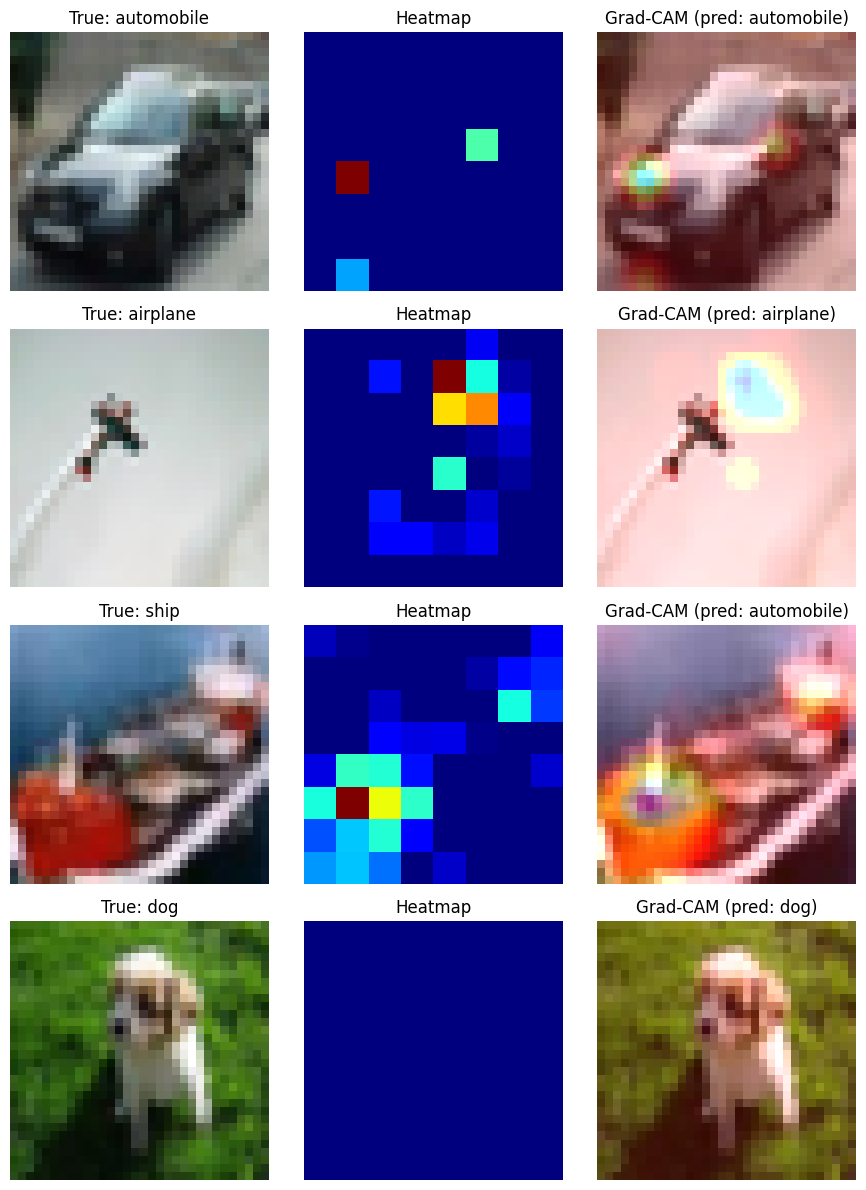

In [16]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # img_array shape: (1, H, W, C), model: keras model
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    # Compute gradients of the top predicted class for the output feature map
    grads = tape.gradient(class_channel, conv_outputs)
    # Mean pooling on the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# Trouver le dernier conv layer name du CNN
for layer in cnn.layers[::-1]:
    if isinstance(layer, layers.Conv2D):
        last_conv_layer_name = layer.name
        break
print('Last conv layer:', last_conv_layer_name)

# Exemple d'utilisation sur quelques images du test set
import cv2

def display_gradcam(img, heatmap, alpha=0.4):
    # img: HxWxC in range [0,1]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + np.uint8(img*255)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')
    return superimposed_img

# Générer Grad-CAM pour quelques images du test set
indices = [0, 1, 2, 3]
fig, axes = plt.subplots(4, 3, figsize=(9,12))
for i, idx in enumerate(indices):
    img = X_test[idx]
    img_input = np.expand_dims(img, axis=0)
    preds = cnn.predict(img_input)
    pred_class = np.argmax(preds[0])
    heatmap = make_gradcam_heatmap(img_input, cnn, last_conv_layer_name, pred_index=pred_class)
    superimposed = display_gradcam(img, heatmap)

    axes[i,0].imshow(img)
    axes[i,0].set_title(f'True: {class_names[y_test[idx]]}')
    axes[i,0].axis('off')

    axes[i,1].imshow(heatmap, cmap='jet')
    axes[i,1].set_title('Heatmap')
    axes[i,1].axis('off')

    axes[i,2].imshow(superimposed)
    axes[i,2].set_title(f'Grad-CAM (pred: {class_names[pred_class]})')
    axes[i,2].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'gradcam_examples.png'), dpi=150)
plt.show()


## 8) Interprétation des résultats et pistes d'amélioration

- Analyse des classes mal reconnues via la matrice de confusion et exemples d'erreurs.
- Pistes : data augmentation, régularisation plus forte, architectures pré-entraînées (transfer learning), calibration du modèle, exploration de Grad-CAM/SHAP plus approfondie.

## 9) Livrables
- Notebook `.ipynb` (ce fichier)
- Figures PNG dans le dossier `outputs/` (courbes, confusion matrices, Grad-CAM)